## Crop
The idea of this notebook is to crop out a reactangular region of the masks for later classification. The following simplifications are done, which could also be relaxed:

* Currently for each image the largest tumour region is taken.
* Only tumors are taken into account
* A recatangular region is cut out keeping the aspect ratio, it is then scaled to 48x48
* Sometimes this results in out of bound regions, these cases are ignored for the time being.

In [5]:
SHAPE = (48,48)

import pickle
import gzip
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time

In [27]:
fileName = '/home/dueo/data/Inselspital_2015_07_08/META.pickle'
#fileName = 'GBM_sub.pickle'
with open(fileName) as f:
    Names,X,Y,l = pickle.load(f)
tumor_label = np.max(Y)

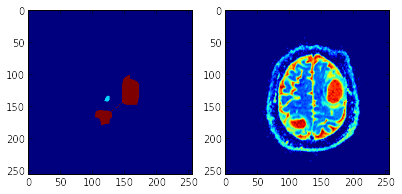

In [28]:
%matplotlib inline
import pylab
idx = 1
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplot(131)
plt.imshow(Y[idx,0,:,:])
plt.subplot(132)
plt.imshow(X[idx,0,:,:])

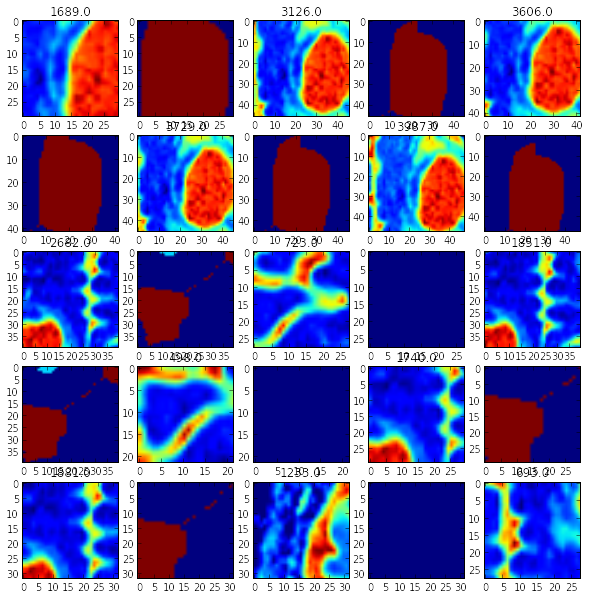

In [37]:
from scipy import ndimage
# Some code taken from: http://scipy-lectures.github.io/advanced/image_processing/
def getLargestTumor(img):
    img[img == 1] = 0
    mask, num = ndimage.label(img)
    sizes = ndimage.sum(img, mask, range(num + 1))
    #plt.imshow(mask)
    maxCluster = np.argmax(sizes)
    if (maxCluster == 0):
        return None
    slice_x, slice_y = ndimage.find_objects(mask == maxCluster)[0]
    #print(sizes[maxCluster])

    # Cropping the largest region 
    x_r = slice_x.stop - slice_x.start
    y_r = slice_y.stop - slice_y.start
    m = max(x_r,y_r)

    x_c = (slice_x.stop + slice_x.start) * 0.5
    y_c = (slice_y.stop + slice_y.start) * 0.5
    slice_x_new = slice(x_c - m/2, x_c + m/2)
    slice_y_new = slice(y_c - m/2, y_c + m/2)

    return (X[idx,0,slice_x_new, slice_y_new],
            Y[idx,0,slice_x_new, slice_y_new], sizes[maxCluster])

allSlices = 0 
for i in range(0,numFiles):
    res = None
    try:
        res = getLargestTumor(np.copy(Y[i,0,:,:]))
        if (res != None):
            if (allSlices < 16):
                plt.subplot(5,5,2*allSlices+1)
                plt.imshow(res[0])
                plt.title(str(res[2]))
                plt.subplot(5,5,2*allSlices+2)
                plt.imshow(res[1])
                plt.title(str(res[2]))
            allSlices = allSlices + 1
    except IndexError:
        pass

1689.0
3126.0
3606.0
3729.0
3987.0
2682.0
723.0
1851.0
498.0
1740.0
1881.0
1233.0
3423.0
14976.0
13443.0
16782.0
2007.0
13134.0
2328.0
12180.0
11403.0
13896.0
14514.0
4887.0
10041.0
10281.0
13149.0
249.0
5613.0
1608.0
5160.0
4731.0
5934.0
7311.0
7164.0
924.0
3258.0
852.0
1053.0
228.0
1836.0
5664.0
3777.0
4917.0
4719.0
3885.0
5112.0
8724.0
3369.0
7698.0
8010.0
1371.0
5865.0
5601.0
4206.0
5079.0
3531.0
1812.0
2784.0
2568.0
2418.0
3324.0
441.0
5559.0
618.0
1809.0
990.0
999.0
5901.0
795.0
1962.0
3489.0
2550.0
1968.0
4974.0
4197.0
4725.0
4089.0
1752.0
1071.0
2853.0
2883.0
6750.0
2160.0
1362.0
1347.0
1989.0
2523.0
951.0
2415.0
4257.0
4092.0
3297.0
4059.0
669.0
3627.0
2517.0
2496.0
5127.0
6048.0
3624.0
1512.0
6336.0
6393.0
3033.0
2517.0
1323.0
4416.0
4377.0
1974.0
699.0
3996.0
5250.0
1524.0
1863.0
4908.0
4209.0
3462.0
6624.0
6165.0
5490.0
4722.0
2085.0
5523.0
5028.0
4524.0
3030.0
2880.0
3048.0
2004.0
3471.0
3228.0
2601.0
6867.0
1404.0
3891.0
6636.0
1758.0
2475.0
5040.0
6420.0
5097.0
6654.0
22

429

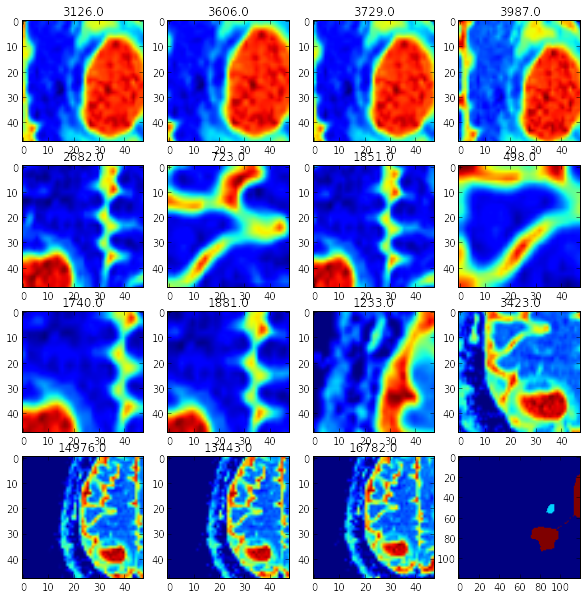

In [36]:
import cv2
numFiles = len(X)  # For Metastasis
X_out = np.zeros((numFiles,1,SHAPE[0], SHAPE[1])) #Change after all slices have been found
Y_out = np.zeros(numFiles)
Names_out = [None] * numFiles
allSlices = 0 
for i in range(0, numFiles):
    res = None
    try:
        res = getLargestTumor(np.copy(Y[i,0,:,:]))
        if (res != None):
            img = res[0]
            dd = cv2.resize(img,(48, 48))
            if (allSlices < 16):
                plt.imshow(dd)
                plt.title(str(res[2]))
                plt.subplot(4,4,allSlices+1)
                plt.imshow(res[1])
            X_out[allSlices,] = dd 
            Y_out[allSlices] = tumor_label
            Names_out[allSlices] = Names[i]
            allSlices += 1
    except IndexError:
        pass
allSlices

In [26]:
with open('/home/dueo/data/Inselspital_2015_07_08/GBM_tumors.pickle', 'wb') as f:
    pickle.dump((Names_out[0:allSlices],X_out[0:allSlices,:,:,:],Y_out[0:allSlices]), f, -1)
%ls -rlh /home/dueo/data/Inselspital_2015_07_08/

total 3.1G
-rw-r--r--  1 dueo dueo  9.1M Jul 17 16:12 META_sub.pickle
-rw-r--r--  1 dueo dueo  455M Jun 18 16:21 metastasis.zip
drwxr-xr-x 68 dueo dueo  4.0K Jun  5 05:26 metastasis/
-r--r--r--  1 dueo dueo 1003M Jul 17 14:01 META.pickle
-rw-r--r--  1 dueo dueo  282K Jun 23 13:07 list_meta.txt
-rw-r--r--  1 dueo dueo  269K Jun 23 13:05 list_GBM.txt
-rw-r--r--  1 dueo dueo  509M Jun 18 16:22 GBM.zip
-rw-r--r--  1 dueo dueo  8.9M Jul 17 20:04 GBM_tumors.pickle
-rw-r--r--  1 dueo dueo  9.1M Jul 17 16:12 GBM_sub.pickle
-r--r--r--  1 dueo dueo  1.1G Jul 16 17:31 GBM.pickle
drwxr-xr-x 62 dueo dueo  4.0K Jun  5 04:43 GBM/


In [31]:
Y_out[0:allSlices]

array([ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3